In [1]:
import os, sys
BASEDIR = "/Users/dhanley/Documents/deep_researcher/"
sys.path += [BASEDIR, f"{BASEDIR}/src"]

In [2]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Research Supervisor

*The supervisor has a simple job: delegate research tasks to an appropriate number of sub-agents.*

Here is our overall research flow:

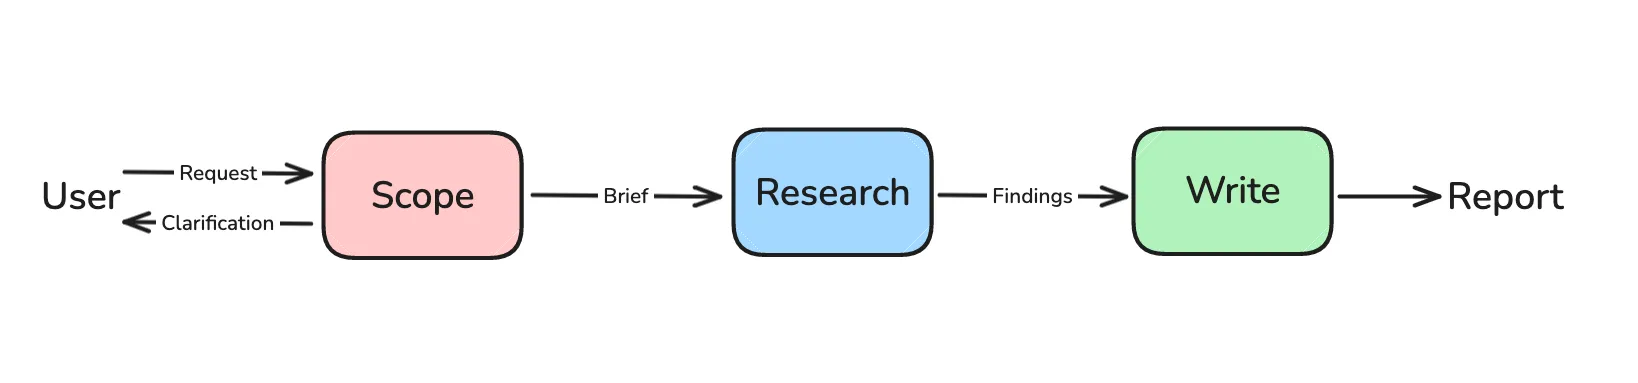

We previously built a research agent bound to either custom tools or MCP server. Now, what happens if the request is complex and has several sub-topics? Single agent response quality *can* suffer with multiple sub-topics (e.g., compare A to B to C) because a single context window needs to store and reason about tool feedback across all of the sub-topics. 

[Numerous failure modes](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), such as [context clash](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), become prevalent as the context window accumulates tool calls across many different sub-topics. As discussed in [Anthropic's blog post](https://www.anthropic.com/engineering/built-multi-agent-research-system), multi-agent systems can split sub-topic to sub-agents with isolated context windows. We'll build a system where a supervisor determines if the research brief can be broken-down into independent sub-topics and delegates to sub-agents with isolated context windows. 

<!-- 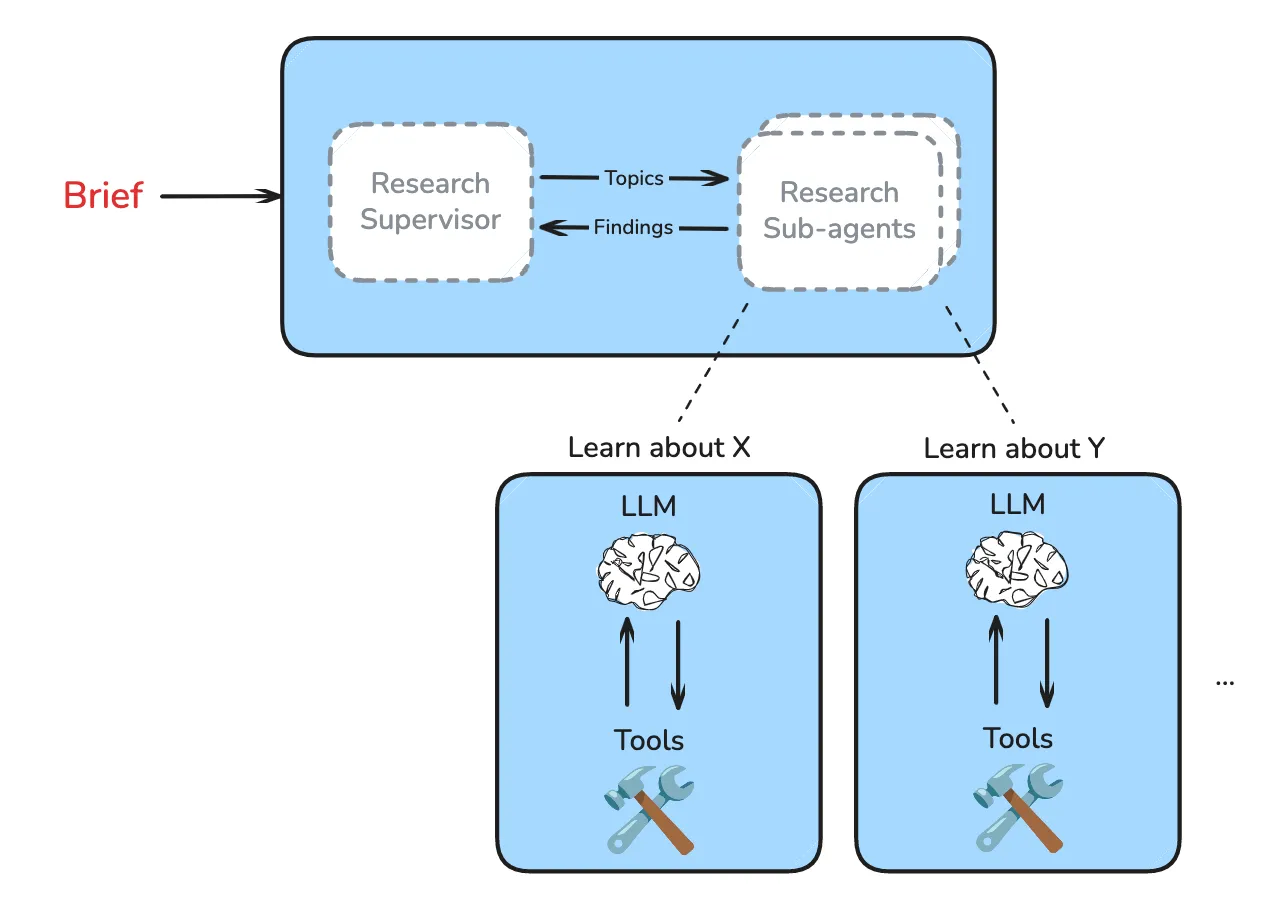 -->

### Prompt

Now, let's design a prompt for the supervisor that follows the principles we've discussed, and include some insights from [the research literature](https://www.anthropic.com/engineering/built-multi-agent-research-system).

#### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the research. Are there multiple independent directions that can be explored simultaneously?
- **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still missing?

#### 2. Concrete Heuristics (For task delegation)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Bias towards single agent** - Use single agent for simplicity unless the user request has clear opportunity for parallelization. 
- **Stop when you can answer confidently** - Don't keep delegating research for perfection.
- **Limit tool calls** - Always stop after 3 tool calls to ConductResearch if you cannot find the right source(s).

#### 3. Show your thinking
Before you call ConductResearch tool call, use think_tool to plan your approach:
- Can the task be broken down into smaller sub-tasks?

After each ConductResearch tool call, use think_tool to analyze the results:
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

#### 4. Scaling rules
Simple fact-finding, lists, and rankings can use a single sub-agent.
- *Example*: List the top 10 coffee shops in San Francisco -> Use 1 sub-agent

Comparisons presented in the user request can use a sub-agent for each element of the comparison.
- *Example*: Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety -> Use 3 sub-agents.
- Delegate clear, distinct, non-overlapping subtopics

In [3]:
from utils import show_prompt
from deep_research_from_scratch.prompts import lead_researcher_prompt
show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to three main tools:                                                                           │
│  1. **ConductResearch**: Delegate research tasks to specialized sub-agents                                      │
│  2. **ResearchComplete**: Indicate that research is complete                                                    │
│  3. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each                │
│  ConductResearch to assess progress**                                                                           │
│  **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously,  │
│  make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is   │
│  more efficient than sequential research for comparative or multi-faceted questions. Use at most                │
│  {max_concurrent_research_units} parallel agents per iteration.                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a research manager with limited time and resources. Follow these steps:                             │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the    │
│  research. Are there multiple independent directions that can be explored simultaneously?                       │
│  3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still         │
│  missing?                                                                                                       │
│  </Instructions>                                      

### State

The supervisor state manages the overall research coordination, while the researcher state handles individual research tasks.

In [5]:
%%writefile ../src/deep_research_from_scratch/state_multi_agent_supervisor.py

"""
State Definitions for Multi-Agent Research Supervisor

This module defines the state objects and tools used for the multi-agent
research supervisor workflow, including coordination state and research tools.
"""

import operator
from typing_extensions import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.
    
    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """
    
    # Messages exchanged with supervisor for coordination and decision-making
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Detailed research brief that guides the overall research direction
    research_brief: str
    # Processed and structured notes ready for final report generation
    notes: Annotated[list[str], operator.add] = []
    # Counter tracking the number of research iterations performed
    research_iterations: int = 0
    # Raw unprocessed research notes collected from sub-agent research
    raw_notes: Annotated[list[str], operator.add] = []

@tool
class ConductResearch(BaseModel):
    """Tool for delegating a research task to a specialized sub-agent."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

Overwriting ../src/deep_research_from_scratch/state_multi_agent_supervisor.py


### Multi-agent 

Now, we'll define our agent. A multi-agent system is a system that consists of multiple agents that work together to complete a task. The main benefit is context isolated, as discussed in [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/). 

In [8]:
%%writefile ../src/deep_research_from_scratch/multi_agent_supervisor.py

"""Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import os, asyncio

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import (
    HumanMessage, 
    BaseMessage, 
    SystemMessage, 
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import lead_researcher_prompt
from deep_research_from_scratch.research_agent import researcher_agent
from deep_research_from_scratch.state_multi_agent_supervisor import (
    SupervisorState, 
    ConductResearch, 
    ResearchComplete
)
from deep_research_from_scratch.utils import get_today_str, think_tool

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.
    
    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.
    
    Args:
        messages: List of messages from supervisor's conversation history
        
    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# Ensure async compatibility for Jupyter environments
try:
    import nest_asyncio
    # Only apply if running in Jupyter/IPython environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Not in Jupyter, no need for nest_asyncio
except ImportError:
    pass  # nest_asyncio not available, proceed without it


# ===== CONFIGURATION =====

supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
# supervisor_model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")
model_args = dict(azure_endpoint="https://llm-proxy.perflab.nvidia.com",
    api_key=os.getenv("PERFLAB_ONEAPI"),
    api_version="2025-02-01-preview",)
supervisor_model = AzureChatOpenAI(
    deployment_name=os.getenv("RESEARCH_MODEL", "claude-sonnet-4-20250514"),
    temperature=0.0, **model_args)
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# System constants
# Maximum number of tool call iterations for individual researcher agents
# This prevents infinite loops and controls research depth per topic
max_researcher_iterations = 6 # Calls to think_tool + ConductResearch

# Maximum number of concurrent research agents the supervisor can launch
# This is passed to the lead_researcher_prompt to limit parallel research tasks
max_concurrent_researchers = 3

# ===== SUPERVISOR NODES =====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """Coordinate research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    # Prepare system message with current date and constraints
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    
    # Make decision about next research steps
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Execute supervisor decisions - either conduct research or end the process.
    
    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # Initialize variables for single return pattern
    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"  # Default next step
    should_end = False
    
    # Check exit criteria first
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END
    
    else:
        # Execute ALL tool calls before deciding next step
        try:
            # Separate think_tool calls from ConductResearch calls
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "think_tool"
            ]
            
            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            # Handle think_tool calls (synchronous)
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )

            # Handle ConductResearch calls (asynchronous)
            if conduct_research_calls:
                # Launch parallel research agents
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    }) 
                    for tool_call in conduct_research_calls
                ]

                # Wait for all research to complete
                tool_results = await asyncio.gather(*coros)

                # Format research results as tool messages
                # Each sub-agent returns compressed research findings in result["compressed_research"]
                # We write this compressed research as the content of a ToolMessage, which allows
                # the supervisor to later retrieve these findings via get_notes_from_tool_calls()
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]
                
                tool_messages.extend(research_tool_messages)

                # Aggregate raw notes from all research
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in tool_results
                ]
                
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END
    
    # Single return point with appropriate state updates
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

# ===== GRAPH CONSTRUCTION =====

# Build supervisor graph
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()

Overwriting ../src/deep_research_from_scratch/multi_agent_supervisor.py


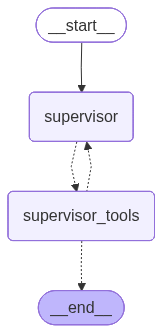

In [7]:
from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# Show the agent
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
# Run the multi-agent supervisor agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Let me analyze this research request carefully:\n\n**What the user needs:**\n- Identify and    │
│ evaluate the best coffee shops in San Francisco based specifically on coffee quality\n- Focus on coffee quality │
│ as the primary criterion (not ambiance, location, wifi, food)\n- Use multiple methods to assess quality: expert │
│ reviews, customer ratings, specialty coffee certifications\n- Prioritize primary sources: official websites,    │
│ reputable coffee review organizations, review aggregators\n- Result should be a well-supported list/ranking     │
│ with latest data as of July 2025\n\n**Research approach considerations:**\nThis is a comprehensive fact-finding │
│ and ranking task that requires:\n1. Identifying top coffee shops in San Francisco\n2. Evaluating them           │
│ specifically on coffee quality metrics\n3. Using multiple assessment methods and sources\n4. Creating a         │
│ supported ranking\n\n**Should I use parallel research?**\nThis seems like a task that could benefit from a      │
│ single comprehensive research agent since:\n- It's focused on one geographic area (San Francisco)\n- It's one   │
│ primary criterion (coffee quality)\n- The research methodology involves synthesizing multiple sources rather    │
│ than comparing distinct entities\n- A single agent can systematically work through identification \u2192        │
│ evaluation \u2192 ranking\n\nI think one well-instructed research agent would be most efficient here, as they   │
│ can build upon findings iteratively and create a cohesive analysis."                                            │
│ }                                                                                                               │
│    ID: tooluse_7BpWaa76R1GekzqHOpFAGA                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Let me analyze this research request carefully:                                            │
│                                                                                                                 │
│ **What the user needs:**                                                                                        │
│ - Identify and evaluate the best coffee shops in San Francisco based specifically on coffee quality             │
│ - Focus on coffee quality as the primary criterion (not ambiance, location, wifi, food)                         │
│ - Use multiple methods to assess quality: expert reviews, customer ratings, specialty coffee certifications     │
│ - Prioritize primary sources: official websites, reputable coffee review organizations, review aggregators      │
│ - Result should be a well-supported list/ranking with latest data as of July 2025                               │
│                                                                                                                 │
│ **Research approach considerations:**                                                                           │
│ This is a comprehensive fact-finding and ranking task that requires:                                            │
│ 1. Identifying top coffee shops in San Francisco                                                                │
│ 2. Evaluating them specifically on coffee quality metrics                                                       │
│ 3. Using multiple assessment methods and sources                                                                │
│ 4. Creating a supported ranking                                                                                 │
│                                                                                                                 │
│ **Should I use parallel research?**                                                                             │
│ This seems like a task that could benefit from a single comprehensive research agent since:                     │
│ - It's focused on one geographic area (San Francisco)                                                           │
│ - It's one primary criterion (coffee quality)                                                                   │
│ - The research methodology involves synthesizing multiple sources rather than comparing distinct entities       │
│ - A single agent can systematically work through identification → evaluation → ranking                          │
│                                                                                                                 │
│ I think one well-instructed research agent would be most efficient here, as they can build upon findings        │
│ iteratively and create a cohesive analysis.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Identify and evaluate the best coffee shops in San Francisco based specifically on coffee  │
│ quality as the primary criterion. Research should focus on analyzing coffee shops within San Francisco using    │
│ multiple assessment methods including expert reviews, customer ratings focused on coffee quality, and specialty │
│ coffee certifications. Prioritize primary sources such as official websites of coffee shops, reputable          │
│ third-party coffee review organizations like Coffee Review or Specialty Coffee Association, and prominent       │
│ review aggregators like Google Reviews and Yelp where direct customer feedback about coffee quality can be      │
│ found. Ignore factors like ambiance, location, wifi, or food options unless they directly impact perceived      │
│ coffee quality. Create a well-supported list or ranking of the top coffee shops in San Francisco with emphasis  │
│ on their coffee quality according to the latest available data. For each coffee shop identified, provide        │
│ specific evidence of their coffee quality including sources, ratings, certifications, awards, or notable        │
│ mentions from coffee experts and customers."                                                                    │
│ }                                                                                                               │
│    ID: tooluse_XNO-eqbATNutnOVVa4Oldw                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. Searched for "best coffee shops San Francisco coffee quality expert reviews specialty coffee 2024" to        │
│ identify top coffee shops and expert reviews.                                                                   │
│ 2. Searched for "Saint Frank Coffee Sextant Coffee Andytown Coffee San Francisco specialty coffee association   │
│ awards certifications coffee quality ratings" to find certifications, awards, and ratings.                      │
│ 3. Searched for "Coffee Review San Francisco coffee shops ratings scores specialty coffee association awards    │
│ Blue Bottle Sightglass" for professional ratings and awards.                                                    │
│ 4. Searched for "Blue Bottle Coffee Sightglass Coffee Ritual Coffee San Francisco coffee quality reviews        │
│ ratings specialty coffee certifications" for reviews and certifications.                                        │
│ 5. Searched for "San Francisco coffee shops Google Reviews ratings coffee quality customer feedback Four Barrel │
│ Coffee Ritual Coffee Blue Bottle Sightglass reviews" for customer feedback and ratings.                         │
│ 6. Searched for "Four Barrel Coffee Ritual Coffee Roasters Blue Bottle Coffee San Francisco coffee quality      │
│ reviews ratings customer feedback specialty coffee" for more customer feedback and quality reviews.             │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ **San Francisco Chronicle's 2025 guide highlights the vibrant and diverse coffee scene in the San Francisco Bay │
│ Area, emphasizing its historic and cultural significance. The article, authored by Cesar Hernandez, showcases   │
│ 27 top coffee shops across cities including San Francisco, Oakland, San Jose, Napa, Burlingame, and Walnut      │
│ Creek. It notes the rise of coffee popups evolving into full cafes, the introduction of the Bay Area's first    │
│ coffee omakase, and the influence of global flavors such as Yemeni, Indonesian, Latino, and Asian on local      │
│ coffee offerings. Specialty drinks like espresso tonics, co-fermented coffees, and unique blends are featured.  │
│ Each coffee shop is described with details on location, ambiance, signature drinks, seating options, and        │
│ operational hours. Notable establishments include 1 oz Coffee, Academic Coffee, Ain’t Normal Cafe, Backhaus,    │
│ The Caffè, The Coffee Movement, Komakase, and Saint Frank, among others. The guide also provides links to       │
│ related lists for best restaurants, outdoor dining, and desserts in the Bay Area. Overall, it presents the Bay  │
│ Area as a premier destination for coffee enthusiasts seeking innovative and culturally rich coffee experiences. │
│ Behind gold, sourdough bread and oxygen, I’d argue that coffee is the Bay Area’s greatest fuel. Coffee popups   │
│ are a major area of change, bringing youthful vigor, fresh perspectives and new formats — like the Bay Area’s   │
│ first coffee omakase. Cultural influences play a central role for new shops, bringing unprecedented diversity   │
│ to the cup, including Yemeni, Indonesian, Latino and As

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Let me analyze the research findings to assess if I have enough information to provide a       │
│ comprehensive answer about the best coffee shops in San Francisco based on coffee quality:\n\n**What I          │
│ found:**\n1. **Multiple authoritative sources**: San Francisco Chronicle (2025), Eater SF (2025), The           │
│ Infatuation, plus official websites and review aggregators\n2. **Consistent top performers**: Several coffee    │
│ shops appear repeatedly across sources:\n   - Saint Frank Coffee - mentioned in multiple sources, known for     │
│ minimal aesthetic and Bolivian coffees\n   - Blue Bottle Coffee - consistently ranked, multiple locations,      │
│ specialty coffee pioneer\n   - Ritual Coffee Roasters - highly rated (1983 reviews), part of \"third wave       │
│ coffee\" movement\n   - Sightglass Coffee - consistently mentioned, 2161 reviews\n   - Four Barrel Coffee -     │
│ 2235 reviews, highly regarded\n   - Andytown Coffee Roasters - west side favorite with Guatemalan               │
│ espresso\n\n3. **Quality indicators found**:\n   - Expert reviews from SF Chronicle and Eater SF (reputable     │
│ food publications)\n   - High customer review counts and ratings on Yelp\n   - Recognition as \"third wave      │
│ coffee\" pioneers\n   - Specialty coffee certifications and direct trade relationships\n   - Awards and         │
│ industry recognition\n\n4. **Specific coffee quality evidence**:\n   - Saint Frank: Known for Bolivian coffees, │
│ relational sourcing\n   - Blue Bottle: Ethically sourced, small-batch roasted, part of specialty coffee         │
│ movement\n   - Ritual: Builds relationships with growers, roasts on-site, \"third wave coffee\"\n   -           │
│ Sightglass: World-renowned roaster\n   - Andytown: Guatemalan espresso focus\n\n**What's missing:**\n- Specific │
│ Coffee Review scores or Specialty Coffee Association ratings\n- More detailed technical coffee quality metrics  │
│ (cupping scores, etc.)\n- Recent awards or certifications from 2024-2025\n\n**Assessment:**\nI have substantial │
│ information from multiple reputable sources to create a well-supported ranking. The sources include the exact   │
│ types requested (expert reviews from food publications, customer ratings, official websites). While I don't     │
│ have specific Coffee Review scores, I have comprehensive coverage from other authoritative sources that focus   │
│ specifically on coffee quality. The data is current (2025) and covers the key players consistently mentioned    │
│ across sources.\n\nI believe I have enough information to provide a comprehensive answer that meets the user's  │
│ requirements."                                                                                                  │
│ }                                                                                                               │
│    ID: tooluse_cm3BPYPKSVeN-_FNw7KHzw                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Let me analyze the research findings to assess if I have enough information to provide a   │
│ comprehensive answer about the best coffee shops in San Francisco based on coffee quality:                      │
│                                                                                                                 │
│ **What I found:**                                                                                               │
│ 1. **Multiple authoritative sources**: San Francisco Chronicle (2025), Eater SF (2025), The Infatuation, plus   │
│ official websites and review aggregators                                                                        │
│ 2. **Consistent top performers**: Several coffee shops appear repeatedly across sources:                        │
│    - Saint Frank Coffee - mentioned in multiple sources, known for minimal aesthetic and Bolivian coffees       │
│    - Blue Bottle Coffee - consistently ranked, multiple locations, specialty coffee pioneer                     │
│    - Ritual Coffee Roasters - highly rated (1983 reviews), part of "third wave coffee" movement                 │
│    - Sightglass Coffee - consistently mentioned, 2161 reviews                                                   │
│    - Four Barrel Coffee - 2235 reviews, highly regarded                                                         │
│    - Andytown Coffee Roasters - west side favorite with Guatemalan espresso                                     │
│                                                                                                                 │
│ 3. **Quality indicators found**:                                                                                │
│    - Expert reviews from SF Chronicle and Eater SF (reputable food publications)                                │
│    - High customer review counts and ratings on Yelp                                                            │
│    - Recognition as "third wave coffee" pioneers                                                                │
│    - Specialty coffee certifications and direct trade relationships                                             │
│    - Awards and industry recognition                                                                            │
│                                                                                                                 │
│ 4. **Specific coffee quality evidence**:                                                                        │
│    - Saint Frank: Known for Bolivian coffees, relational sourcing                                               │
│    - Blue Bottle: Ethically sourced, small-batch roasted, part of specialty coffee movement                     │
│    - Ritual: Builds relationships with growers, roasts on-site, "third wave coffee"                             │
│    - Sightglass: World-renowned roaster                                                                         │
│    - Andytown: Guatemalan espresso focus                                                                        │
│                                                                                                                 │
│ **What's missing:**                                                                                             │
│ - Specific Coffee Review scores or Specialty Coffee Association ratings                                         │
│ - More detailed technical coffee quality metrics (cupping scores, etc.)                                         │
│ - Recent awards or certifications from 2024-2025                                                                │
│                                                                                                                 │
│ **Assessment:**                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ResearchComplete                                                                                  │
│    Args: {}                                                                                                     │
│    ID: tooluse_LbSZFoPmT1qhP2DzU2qX-w                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

We can look at the trace [here](https://smith.langchain.com/public/99eaaecd-fd9a-4ead-8eed-abdfe4ab9288/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

This agent has been added to the `langgraph.json` file, so you can select `research_agent_supervisor` in the dropdown menu:

```
"research_agent_supervisor": "./src/deep_research_from_scratch/multi_agent_supervisor.py:supervisor_agent",
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Eval

The clear benefit of multi-agent is context isolation when there are clearly separable sub-topics. As we discuss [in our blog](https://blog.langchain.com/open-deep-research/): 

> Our experiments showed that single agent response quality suffers if the request has multiple sub-topics (e.g., compare A to B to C). The intuition here is straightforward: a single context window needs to store and reason about tool feedback across all of the sub-topics. This tool feedback is often token heavy. Numerous failure modes, such as context clash, become prevalent as the context window accumulates tool calls across many different sub-topics.

But, we want to be careful not to spawn sub-agents in cases where it is not required:

> The supervisor can handle both cases by selectively spawning sub-agents to tune the level of research depth needed for a request. The supervisor is prompted with heuristics to reason about when research should be parallelized, and when a single thread of research is sufficient. Our deep research agent has the flexibility to choose whether to parallelize research or not.

Let's set up a few tests to make sure that we are parallelizing when it makes sense.

In [10]:
# Example messages with think_tool calls and tool messages for evaluation
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

should_parallelize = [
    HumanMessage(content="Compare OpenAI vs Gemini deep research."),
    AIMessage(content="I need to analyze this request to determine if can should be parallelized.", tool_calls=[
        {
            "name": "think_tool",
            "args": {"reflection": "This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research."},
            "id": "call_think_1"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research.", tool_call_id="call_think_1", name="think_tool")
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Chelsea, Manhattan"),
    AIMessage(content="Let me think about whether this task requires parallelization.", tool_calls=[
        {
            "name": "think_tool", 
            "args": {"reflection": "This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan)."},
            "id": "call_think_2"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan).", tool_call_id="call_think_2", name="think_tool")
]

In [11]:
import os
from langsmith import Client

# Initialize client 
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_supervisor_parallelism"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"supervisor_messages": should_parallelize},
                "outputs": {"num_expected_threads": 2},
            },
            {
                "inputs": {"supervisor_messages": should_not_parallelize},
                "outputs": {"num_expected_threads": 1},
            },
        ],
    )

Now we can run evals.

In [12]:
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)

await langsmith_client.aevaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_parallelism],
    experiment_prefix="Supervisor Parallelism",
)

View the evaluation results for experiment: 'Supervisor Parallelism-abc264a3' at:
https://smith.langchain.com/o/507e9840-7897-4f0b-9027-aa14afeec8f5/datasets/a3689707-d173-42b4-bf19-973b942e6cad/compare?selectedSessions=f7231b39-a3cd-404f-bd4a-34f857fbd1d8




0it [00:00, ?it/s]

,inputs.supervisor_messages,outputs.output,error,reference.num_expected_threads,feedback.correct_next_step,execution_time,example_id,id
0,"[{'type': 'human', 'content': 'Compare OpenAI ...",Command(update={'supervisor_messages': [AIMess...,None,2,True,4.916623,049a99b6-4ada-4856-8340-76221086baca,0ba44e41-e3cc-431d-8efc-2b07c380a51b
1,"[{'type': 'human', 'content': 'What are the to...",Command(update={'supervisor_messages': [AIMess...,None,1,True,4.459894,f09debd0-408e-4c98-b439-e8f5b0b9d3c7,ff5909de-21c6-4bc8-a981-da9b5c6cc1d4


In the first example, we asked the agent to compare and contrast products.

This sort of problem is great for parallel research, and we expect the agent to deep dive into each lab in parallel before synthesizing findings when writing the report.

The second example asks the agent for the top restaurants in Chelsea, Manhattan. 

The agent needs to conduct a single thread of research here and reflect on websites that presumably list out highly rated restaurants. 

There's not an obvious opportunity for parallelism for this ranking task.